In [1]:
import os
import random
import csv
import torch
from datasets import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
from nnsight import LanguageModel
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from einops import einsum, rearrange, reduce

from utils import get_both_stories

random.seed(10)

%load_ext autoreload
%autoreload 2

# Loading model

In [2]:
if os.environ.get("USER") == 'nikhil_prakash':
    model = LanguageModel(
        "/data/public_models/huggingface/meta-llama/Meta-Llama-3-70B-Instruct",
        device_map="auto",
        load_in_4bit=True,
        torch_dtype=torch.float16,
        dispatch=True,
    )
else:
    model = LanguageModel(
        "meta-llama/Meta-Llama-3-70B-Instruct",
        device_map="auto",
        load_in_4bit=True,
        torch_dtype=torch.float16,
        dispatch=True,
    )

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

# Loading data

In [3]:
variable = "0_forward_belief"

with open(f"data/bigtom/{variable}_true_belief/stories.csv", "r") as f:
    reader = csv.reader(f, delimiter=";")
    tb_data = list(reader)

with open(f"data/bigtom/{variable}_false_belief/stories.csv", "r") as f:
    reader = csv.reader(f, delimiter=";")
    fb_data = list(reader)

with open(f"data/bigtom/{variable}_true_control/stories.csv", "r") as f:
    reader = csv.reader(f, delimiter=";")
    tb_control = list(reader)

with open(f"data/bigtom/{variable}_false_control/stories.csv", "r") as f:
    reader = csv.reader(f, delimiter=";")
    fb_control = list(reader)

# Circuit Discovery

In [163]:
n_samples = 20
batch_size = 1
samples = get_both_stories(fb_data, tb_data, n_samples)

dataset = Dataset.from_list(samples)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [148]:
# n_samples = 20
# batch_size = 1
# clean_samples = []
# method_name = "0shot"

# with open(f"prompt_instructions/{method_name}.txt", "r") as f:
#     instructions = f.read()

# for example in tb_data[: n_samples//2] + fb_data[: n_samples//2]:
#     story, clean_question_raw, correct_answer, wrong_answer = example
#     answers = [correct_answer, wrong_answer]
#     random.shuffle(answers)

#     clean_question = f"{clean_question_raw}\nChoose one of the following:\na) {answers[0]}\nb) {answers[1]}"
#     corrupt_question = f"{clean_question_raw}\nChoose one of the following:\na) {answers[1]}\nb) {answers[0]}"

#     clean_prompt = f"Instructions: {instructions}\nStory: {story}\nQuestion: {clean_question}\nAnswer:"
#     corrupt_prompt = f"Instructions: {instructions}\nStory: {story}\nQuestion: {corrupt_question}\nAnswer:"

#     if answers[0] == correct_answer:
#         clean_target = " a"
#         corrupt_target = " b"
#     else:
#         clean_target = " b"
#         corrupt_target = " a"

#     clean_samples.append({"clean_prompt": clean_prompt, "clean_target": clean_target, "corrupt_prompt": corrupt_prompt, "corrupt_target": corrupt_target})

# # Create dataloader using clean_samples
# dataset = Dataset.from_list(clean_samples)
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [164]:
def metric_fn(model, clean_target, corrupt_target):
    clean_target_token_idx = model.tokenizer(clean_target, return_tensors="pt", padding=False)["input_ids"][:, -1]
    corrupt_target_token_idx = model.tokenizer(corrupt_target, return_tensors="pt", padding=False)["input_ids"][:, -1]

    logit_diff = torch.gather(
        model.lm_head.output[:, -1], dim=-1, index=corrupt_target_token_idx.view(-1, 1)
    ) - torch.gather(
        model.lm_head.output[:, -1], dim=-1, index=clean_target_token_idx.view(-1, 1)
    )
    logit_diff = logit_diff.squeeze(-1)
    return logit_diff

## Component Patching

In [165]:
n_layers = 30
attribution_score = torch.zeros(len(dataloader), n_layers, model.config.num_attention_heads).cpu()

for batch_idx, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
    clean_prompt = batch["clean_prompt"]
    corrupt_prompt = batch["corrupt_prompt"]
    clean_target = batch["clean_target"]
#     corrupt_target = batch["corrupt_target"]
    corrupt_target = []
    for i in range(len(clean_target)):
        if clean_target[i] == " a":
            corrupt_target.append(" b")
        else:
            corrupt_target.append(" a")

    upstream_act_clean, upstream_act_corrupt, grads_downstream = {}, {}, {}
    with model.trace(clean_prompt, scan=False, validate=False):
        for layer_idx in range(n_layers):
            head_out = model.model.layers[layer_idx].self_attn.o_proj.input[0][0]
            upstream_act_clean[layer_idx] = head_out.cpu().save()
            grads_downstream[layer_idx] = head_out.grad.cpu().save()

        metric_clean = metric_fn(model, clean_target, corrupt_target)
        metric_clean.sum().backward()

    upstream_act_clean = {k: v.value.cpu() for k, v in upstream_act_clean.items()}
    grads_downstream = {k: v.value.cpu() for k, v in grads_downstream.items()}
    
    model.zero_grad(set_to_none=True)
    torch.cuda.empty_cache()
    
    with torch.no_grad():
        with model.trace(corrupt_prompt, scan=False, validate=False), torch.inference_mode():
            for layer_idx in range(n_layers):
                head_out = model.model.layers[layer_idx].self_attn.o_proj.input[0][0]
                upstream_act_corrupt[layer_idx] = head_out.cpu().save()

            metric_corrupt = metric_fn(model, clean_target, corrupt_target)

    upstream_act_corrupt = {k: v.value.cpu() for k, v in upstream_act_corrupt.items()}
    
    torch.cuda.empty_cache()

    d_head = model.config.hidden_size // model.config.num_attention_heads
    with torch.no_grad(), torch.inference_mode():
        for layer_idx in range(n_layers):
            clean_state, corrupt_state, grad = upstream_act_clean[layer_idx], upstream_act_corrupt[layer_idx], grads_downstream[layer_idx]
            clean_state, corrupt_state, grad = clean_state[:, -1], corrupt_state[:, -1], grad[:, -1]
            delta = (corrupt_state - clean_state).detach()
            score = delta * grad

            # Averaging over all batch items and analysing components only at last token position
            score = score.mean(dim=0)
            score = rearrange(score, "(n_heads d_head) -> n_heads d_head", n_heads=model.config.num_attention_heads)
            score = reduce(score, "n_heads d_head -> n_heads", "sum")
            attribution_score[batch_idx][layer_idx] = score

        del upstream_act_clean[layer_idx], upstream_act_corrupt[layer_idx], grads_downstream[layer_idx], clean_state, corrupt_state, grad, score
        torch.cuda.empty_cache()

torch.save(attribution_score, "story_heads_attribution_score.pt")

100%|██████████| 20/20 [02:22<00:00,  7.12s/it]


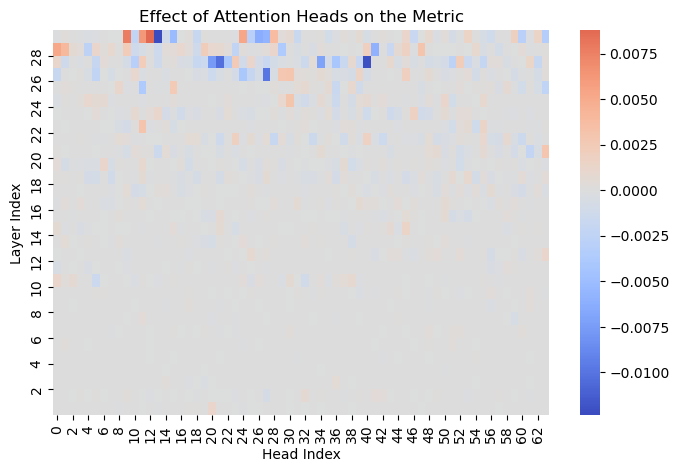

In [166]:
attribution_score = torch.load("story_heads_attribution_score.pt")
story_head_effects = attribution_score.mean(dim=0)

# Visualize the effects list using a heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(story_head_effects.flip(0), cmap="coolwarm", center=0, cbar=True)
plt.xlabel("Head Index")
plt.ylabel("Layer Index")
plt.title("Effect of Attention Heads on the Metric")
plt.yticks(ticks=list(range(2, n_layers, 2)), labels=list(range(2, n_layers, 2))[::-1])
plt.show()

In [171]:
k = 30
topk_heads = story_head_effects.view(-1).topk(k, largest=True).indices
top_story_heads = [((idx // model.config.num_attention_heads).item(), (idx % model.config.num_attention_heads).item()) for idx in topk_heads]
for l, h in top_story_heads:
    print(f"Layer {l}, Head {h}")

Layer 29, Head 12
Layer 29, Head 9
Layer 29, Head 11
Layer 29, Head 24
Layer 28, Head 0
Layer 28, Head 1
Layer 29, Head 28
Layer 22, Head 11
Layer 28, Head 47
Layer 24, Head 30
Layer 26, Head 30
Layer 20, Head 63
Layer 26, Head 29
Layer 27, Head 23
Layer 25, Head 15
Layer 28, Head 9
Layer 27, Head 11
Layer 27, Head 52
Layer 28, Head 19
Layer 28, Head 40
Layer 26, Head 45
Layer 29, Head 59
Layer 21, Head 23
Layer 28, Head 45
Layer 21, Head 40
Layer 23, Head 46
Layer 26, Head 39
Layer 29, Head 53
Layer 29, Head 62
Layer 22, Head 55


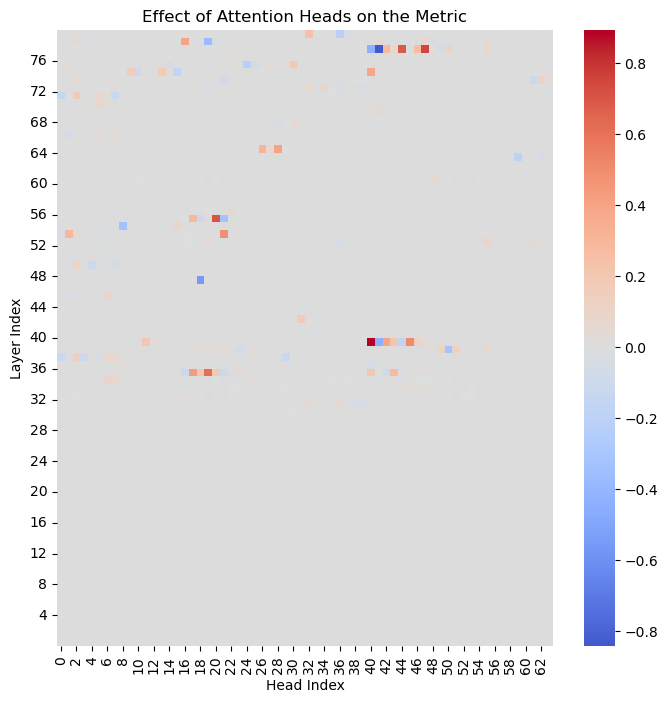

In [45]:
attribution_score = torch.load("option_heads_attribution_score.pt")
option_head_effects = attribution_score.mean(dim=0)

# Visualize the effects list using a heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(option_head_effects.flip(0), cmap="coolwarm", center=0, cbar=True)
plt.xlabel("Head Index")
plt.ylabel("Layer Index")
plt.title("Effect of Attention Heads on the Metric")
plt.yticks(ticks=list(range(4, model.config.num_hidden_layers, 4)), labels=list(range(4, model.config.num_hidden_layers, 4))[::-1])
plt.show()

In [139]:
k = 1
topk_heads = option_head_effects.view(-1).topk(k, largest=True).indices
top_option_heads = [((idx // model.config.num_attention_heads).item(), (idx % model.config.num_attention_heads).item()) for idx in topk_heads]
# for l, h in top_option_heads:
#     print(f"Layer {l}, Head {h}")

In [172]:
circuit_heads = top_option_heads + top_story_heads
print(f"#Heads in circuit: {len(circuit_heads)}")

#Heads in circuit: 31


## Faithfulness

In [152]:
# d_head = model.config.hidden_size // model.config.num_attention_heads
# mean_act = torch.zeros(model.config.num_hidden_layers, model.config.num_attention_heads, d_head)

# with torch.no_grad():
#     for batch in tqdm(dataloader):
#         clean_prompt = batch["clean_prompt"]
#         with model.trace(clean_prompt, scan=False, validate=False):
#             for layer_idx in range(model.config.num_hidden_layers):
#                 head_out = model.model.layers[layer_idx].self_attn.o_proj.input[0][0]
#                 head_out = rearrange(head_out, "batch seqlen (n_heads d_head) -> batch seqlen n_heads d_head", 
#                                      n_heads=model.config.num_attention_heads)
#                 head_out = head_out.sum(dim=0)[-1]
#                 mean_act[layer_idx] += head_out.save()

#     for layer_idx in range(model.config.num_hidden_layers):
#         for head_idx in range(model.config.num_attention_heads):
#             mean_act[layer_idx][head_idx] = mean_act[layer_idx][head_idx] / len(dataloader.dataset)

100%|██████████| 20/20 [00:47<00:00,  2.36s/it]


In [173]:
# accs = {}

with torch.no_grad():
    for start_layer_idx in range(0, model.config.num_hidden_layers, 10):
        correct, total = 0, 0
        for batch in tqdm(dataloader):
            prompt = batch["clean_prompt"]
            target = batch["clean_target"]

            with model.trace(prompt, scan=False, validate=False):
                for layer_idx in range(start_layer_idx, model.config.num_hidden_layers):
                    head_out = model.model.layers[layer_idx].self_attn.o_proj.input[0][0]
                    head_out = rearrange(head_out, "batch seqlen (n_heads d_head) -> batch seqlen n_heads d_head", 
                                         n_heads=model.config.num_attention_heads)

                    for head_idx in range(model.config.num_attention_heads):
                        if (layer_idx, head_idx) not in circuit_heads:
                            head_out[:, -1, head_idx] = mean_act[layer_idx, head_idx]

                    head_out = rearrange(head_out, "batch seqlen n_heads d_head -> batch seqlen (n_heads d_head)", 
                                         n_heads=model.config.num_attention_heads)

                    model.model.layers[layer_idx].self_attn.o_proj.output = model.model.layers[layer_idx].self_attn.o_proj(
                                                                                head_out
                                                                            )

                preds = model.lm_head.output[:, -1].argmax(dim=-1).save()

            for i in range(len(target)):
                if model.tokenizer.decode(preds[i].item()).strip() == target[i].strip():
                    correct += 1
                total += 1

        acc = round(correct/total, 2)
        print(f"Start layer: {start_layer_idx} | Acc: {acc}")
#         accs[start_layer_idx] = acc

100%|██████████| 20/20 [01:03<00:00,  3.15s/it]


Start layer: 0 | Acc: 0.45


 20%|██        | 4/20 [00:13<00:55,  3.45s/it]


KeyboardInterrupt: 

In [162]:
accs

{0: 0.55, 10: 0.55, 20: 0.55, 30: 0.55, 40: 0.95, 50: 0.95, 60: 0.95, 70: 0.95}

## Path Patching

In [30]:
downstream_nodes = [model.lm_head]
upstream_nodes = [model.model.layers[l].self_attn.o_proj for l in range(model.config.num_hidden_layers)]
attribution_score = torch.zeros(
    len(dataloader), model.config.num_hidden_layers, model.config.num_attention_heads
).cpu()

for batch_idx, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
    clean_prompt = batch["clean_prompt"]
    corrupt_prompt = batch["corrupt_prompt"]
    clean_target = batch["clean_target"]
    corrupt_target = batch["corrupt_target"]

    # Computing the upstream activations and downstream gradients for clean prompt
    upstream_act_clean, downstream_grads = {}, {}
    with model.trace(clean_prompt, scan=False, validate=False):
        for node in upstream_nodes:
            node_name = node._module_path[1:]
            head_out = node.input[0][0]
            upstream_act_clean[node_name] = head_out.cpu().save()

        for node in downstream_nodes:
            node_name = node._module_path[1:]
            downstream_grads[node_name] = node.input[0][0].grad.cpu().save()

        metric_clean = metric_fn(model, clean_target, corrupt_target)
        metric_clean.sum().backward()

    upstream_act_clean = {k: v.value.cpu() for k, v in upstream_act_clean.items()}
    downstream_grads = {k: v.value.cpu() for k, v in downstream_grads.items()}

    model.zero_grad(set_to_none=True)
    torch.cuda.empty_cache()


    # Computing the upstream gradients for clean prompt
    upstream_grads = defaultdict(dict)
    for downstream_node in downstream_nodes:
        downstream_node_name = downstream_node._module_path[1:]

        with model.trace(clean_prompt, scan=False, validate=False):
            for upstream_node in upstream_nodes:
                upstream_node_name = upstream_node._module_path[1:]
                upstream_grads[downstream_node_name][upstream_node_name] = (
                    upstream_node.input[0][0].grad.cpu().save()
                )

            metric_score = downstream_node.input[0][0][:, -1].mean(0).sum(0)
            metric_score.backward()

        upstream_grads[downstream_node_name] = {
            k: v.value.cpu() for k, v in upstream_grads[downstream_node_name].items()
        }

        model.zero_grad(set_to_none=True)
        torch.cuda.empty_cache()


    # Computing the upstream activations for corrupt prompt
    upstream_act_corrupt = {}
    with torch.no_grad():
        with model.trace(
            corrupt_prompt, scan=False, validate=False
        ), torch.inference_mode():
            for node in upstream_nodes:
                node_name = node._module_path[1:]
                head_out = node.input[0][0]
                upstream_act_corrupt[node_name] = head_out.cpu().save()

            metric_corrupt = metric_fn(model, clean_target, corrupt_target)

    upstream_act_corrupt = {k: v.value.cpu() for k, v in upstream_act_corrupt.items()}

    torch.cuda.empty_cache()

    
    # Computing the attribution score
    for downstream_node in downstream_nodes:
        downstream_node_name = downstream_node._module_path[1:]
        downstream_grad = downstream_grads[downstream_node_name]

        d_head = model.config.hidden_size // model.config.num_attention_heads
        with torch.no_grad(), torch.inference_mode():
            for upstream_node in upstream_nodes:
                upstream_node_name = upstream_node._module_path[1:]
                clean_state, corrupt_state = (
                    upstream_act_clean[upstream_node_name],
                    upstream_act_corrupt[upstream_node_name],
                )
                upstream_grad = upstream_grads[downstream_node_name][upstream_node_name]

                delta = (corrupt_state - clean_state).detach()
                score = downstream_grad * upstream_grad * delta

                # Averaging over all batch items and analysing components only at last token position
                score = score.mean(dim=0)[-1]
                score = rearrange(
                    score,
                    "(n_heads d_head) -> n_heads d_head",
                    n_heads=model.config.num_attention_heads,
                )
                score = reduce(score, "n_heads d_head -> n_heads", "sum")
                
                layer_idx = int(upstream_node_name.split('.')[2])
                attribution_score[batch_idx][layer_idx] = score

            del (
                upstream_act_clean[upstream_node_name],
                upstream_act_corrupt[upstream_node_name],
                upstream_grads[downstream_node_name][upstream_node_name],
                clean_state,
                corrupt_state,
                score,
            )
            torch.cuda.empty_cache()

100%|██████████| 4/4 [01:47<00:00, 26.92s/it]


In [31]:
effects = attribution_score.mean(dim=0)

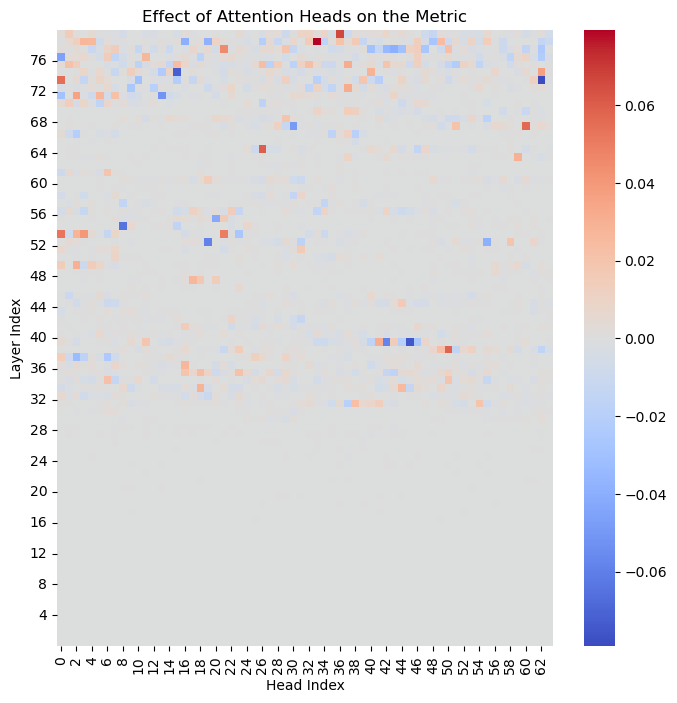

In [34]:
# Visualize the effects list using a heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(effects.flip(0), cmap="coolwarm", center=0, cbar=True)
plt.xlabel("Head Index")
plt.ylabel("Layer Index")
plt.title("Effect of Attention Heads on the Metric")
plt.yticks(
    ticks=list(range(4, model.config.num_hidden_layers, 4)),
    labels=list(range(4, model.config.num_hidden_layers, 4))[::-1],
)
plt.show()

In [33]:
k = 10
topk_heads = effects.view(-1).topk(k).indices
topk_heads = [((idx // model.config.num_attention_heads).item(), (idx % model.config.num_attention_heads).item()) for idx in topk_heads]
for l, h in topk_heads:
    print(f"Layer {l}, Head {h}")

Layer 78, Head 33
Layer 79, Head 36
Layer 64, Head 26
Layer 38, Head 50
Layer 67, Head 60
Layer 73, Head 0
Layer 53, Head 0
Layer 53, Head 21
Layer 77, Head 21
Layer 53, Head 3
